## Final Project  - 3253 Machine Learning

### Michael Ciniello - qq217352

### Comment Volume Prediction using Neural Networks and Decision Trees

Can you validate the results of the paper? Can you build a better model?

- http://uksim.info/uksim2015/data/8713a015.pdf

First, read the paper. Then, download the data here:
- https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

- Can you train and MLP that beats a tuned RF?

  
Considerations:
- Remember all the steps required to complete a ML project
- Where possible include data/ML pipelines and code modularity
- Choose an evaluation metric
- Place utility functions and other code in a file that you can import. See discussion here: https://stackoverflow.com/questions/36427747/scientific-computing-ipython-notebook-how-to-organize-code and https://www.slideshare.net/katenerush/clean-code-in-jupyter-notebooks?next_slideshow=1
- For the MLP part use TensorFlow
- Deadline for submissions no later than Dec. 16th, 2017 by 8am.

Comments: 

- Start with one of the data variations, then build on top of that
- Submit all your final notebooks and external code
- This is an individual project not a group project.

#### Submit solutions:

https://goo.gl/forms/VKOtkxNdzgxufHbf1

## A quick note:

#### **Full disclose, this code is pretty sloppy... Definitely not my best work. However given the time constraints I just had to get it done. I didn't really have time to dig into the NNets piece either, so I just used a very hacky SK wrapper to get the job done. My next step is to thoroughly read the NNETS chapters in the textbook, so hopefully by the time summer rolls around I'll be ready for the next course.**

#### **Anyway, thanks a lot for the fantastic semester and for all of the advice! Talk to you soon!**

In [25]:
#import necessary packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import time

#model metrics
from sklearn import metrics

In [2]:
#set directories
train_dir = 'C:\\Users\\mciniello\\Desktop\\Data Science Fundementals\\Data Mining and Advanced Analytics\\FINAL PROJECT\\Dataset\\Training'
test_dir = 'C:\\Users\\mciniello\\Desktop\\Data Science Fundementals\\Data Mining and Advanced Analytics\\FINAL PROJECT\\Dataset\\Testing'
test_dir_cases = os.path.join(test_dir,'TestSet')

### Import all training & testing files

In [3]:
#import training files
os.chdir(train_dir)

train_dict = {}
for variant in range(1,6):
    file = 'Features_Variant_{}.csv'.format(variant)
    df = pd.read_csv(file, header=None)
    df.columns = df.columns+1
    train_dict[variant] = df
    print(file, 'loaded')

Features_Variant_1.csv loaded
Features_Variant_2.csv loaded
Features_Variant_3.csv loaded
Features_Variant_4.csv loaded
Features_Variant_5.csv loaded


In [4]:
#import 100 row training files
os.chdir(test_dir_cases)

test_dict = {}
for case in range(1,11):
    file = 'Test_Case_{}.csv'.format(case)
    df = pd.read_csv(file, header=None)
    df.columns = df.columns+1
    test_dict[case] = df
    print(file, 'loaded')

Test_Case_1.csv loaded
Test_Case_2.csv loaded
Test_Case_3.csv loaded
Test_Case_4.csv loaded
Test_Case_5.csv loaded
Test_Case_6.csv loaded
Test_Case_7.csv loaded
Test_Case_8.csv loaded
Test_Case_9.csv loaded
Test_Case_10.csv loaded


In [5]:
#import aggregate test data
os.chdir(test_dir)
test_set_agg = pd.read_csv('Features_TestSet.csv', header=None)
test_set_agg.columns = test_set_agg.columns+1
test_set_agg.shape

(10044, 54)

# Create functions to test and visualize models

### Tests function

In [124]:
#reset the graph
def reset_graph(seed=123):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

# create funciton to get name of log directory
from datetime import datetime

In [107]:
def run_tests(model_n, variants=[1,2,3,4,5]):
    #initialize test score lists
    t1_hits10_scores = []
    t2_auc10_scores = []
    t3_time_scores = []
    t4_mae_scores = []
    
    #Train Models
    for var in variants:
        #load data
        X_train = train_dict[var].iloc[:,:-1].as_matrix()
        y_train = np.ravel(train_dict[var].iloc[:,-1:].as_matrix())
        #train model
        if model_n == "nnet":
            reset_graph()
            config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config
            feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
            dnn = tf.contrib.learn.DNNRegressor(hidden_units=[300,150,350,300],
                                                    feature_columns=feature_cols, 
                                                    config=config)
            model = tf.contrib.learn.SKCompat(dnn) # if TensorFlow >= 1.1
        else:
            model=model_n
        time1 = time.time()
        if str(model) == 'SKCompat()':
            model.fit(X_train, y_train, batch_size=50, steps=40000)
        else:
            model.fit(X_train, y_train)
        time2 = time.time()
        model_time = time2-time1
        t3_time_scores.append(model_time)
        
        
        #TEST 1: hits@10
        t1_results = []
        for case in range(1,11):
            #import test data, store indeces of top 10 rows
            X_test = test_dict[case].iloc[:,:-1].as_matrix()
            top10index_ACT = list(test_dict[case].sort_values(54, ascending=False).iloc[0:10,:].index) 
            #predict with test case and store as df
            preds = model.predict(X_test)
            if str(model) == 'SKCompat()':
                preds = preds['scores']            
            preds_df= pd.DataFrame({'preds':preds})
            #extract index of top 10 predicted values by number of comments
            top10index_PRED = list(preds_df.sort_values('preds',ascending=False).iloc[0:10,:].index)
            num_correct = len(np.intersect1d(top10index_ACT, top10index_PRED))
            t1_results.append(num_correct)
        t1_hits10_scores.append(np.average(t1_results))
        
        #TEST 2: AUC@10
        t2_results = []
        for case in range(1,11):
            #import test data, store indeces of top 10 rows
            X_test = test_dict[case].iloc[:,:-1].as_matrix()
            y = list((test_dict[case][54].rank(ascending=False)<11)*1)
            #predict with test case and store as df
            preds = model.predict(X_test)
            if str(model) == 'SKCompat()':
                preds = preds['scores']
            preds_df= pd.DataFrame({'preds':preds})
            #extract index of top 10 predicted values by number of comments
            pred = list((preds_df['preds'].rank(ascending=False)<11)*1)
            fpr, tpr, thresholds = metrics.roc_curve(y, pred)
            auc = metrics.auc(fpr, tpr)
            t2_results.append(auc)
        t2_auc10_scores.append(np.average(t2_results))
        
        #TEST 4: MAE
        X_test = test_set_agg.iloc[:,:-1].as_matrix()
        y_actuals = np.ravel(test_set_agg.iloc[:,-1:].as_matrix())
        preds = model.predict(X_test)
        if str(model) == 'SKCompat()':
            preds = preds['scores']
        mae = metrics.mean_absolute_error(y_actuals, preds)
        t4_mae_scores.append(mae)
        
        print('Variant {}:'.format(str(var)),
              't1=', np.average(np.average(t1_results)),',',
              't2=', np.average(np.average(t2_results)),',', 
              't3=', model_time,',', 
              't4=', mae)

    return t1_hits10_scores, t2_auc10_scores, t3_time_scores, t4_mae_scores

### Visualiztion Function

In [113]:
def show_results(all_tests_dict, width=0.25, colors = ['r','b','g','y','m'], size=(13,13)):
    #FUNCTION STARTS HERE
    #extract n tests from dict
    n_tests = len(all_tests_dict)

    #n_models should be the same for all tests
    n_models = list(all_tests_dict.values())[1].shape[1]

    #set axes
    #fig, ax = plt.subplots()
    f, (ax1, ax2, ax3, ax4) = plt.subplots(n_tests, 1,figsize=size)
    axes = (ax1, ax2, ax3, ax4) 

    # Setting the positions and width for the bars
    pos=[t*(width*6) for t in range(0,n_models)]

    for ax, name, df in zip(axes, all_tests_dict.keys(), all_tests_dict.values()):
        #plot all variants
        for var in range(0,5):
            if var==0:
                p = pos
            p = [x + width*var for x in pos]
            ax.bar(p, 
                    df.iloc[var,:],
                    width, 
                    alpha=0.5, 
                    color=colors[var], 
                    label='Variant_{}'.format(var+1)) 

        ax.set_ylabel('Score')
        ax.set_title(name, size=20)
        ax.set_xticks([x+(width*n_models/2)+width/2 for x in pos])
        ax.set_xticklabels(df.columns)
        ax.set_ylim([np.min([np.min(df.values),0]),np.max([np.max(df.values)])*1.25])
        ax.legend(['Variant_1', 'Variant_2', 'Variant_3','Variant_4', 'Variant_5'], loc='lower right')
        plt.xlim(min(pos)-width, max(pos)+width*5)
        plt.tight_layout()
        
    plt.show()

# Run Some Models

### Create dictionary to store all values in as you go

In [114]:
#set dataframes to store test results
Test1_Hits10 = pd.DataFrame()
Test2_AUC10 = pd.DataFrame()
Test3_TrainTimes = pd.DataFrame()
Test4_MAE = pd.DataFrame()
                            
all_tests = {'T1: Hits@10':Test1_Hits10,
             'T2: AUC@10':Test2_AUC10,
             'T3: Training Time':Test3_TrainTimes, 
             'T4: Mean Absolute Error': Test4_MAE}

def update_dict(orig_dict, mod_name, t_results):
    orig_dict['T1: Hits@10'][mod_name]=t_results[0]
    orig_dict['T2: AUC@10'][mod_name]=t_results[1]
    orig_dict['T3: Training Time'][mod_name]=t_results[2]
    orig_dict['T4: Mean Absolute Error'][mod_name]=t_results[3]
    return orig_dict

### Model 1: Random Forest (Un-Tuned)

In [112]:
#run model
rnd_reg1 = RandomForestRegressor()
m1_t1, m1_t2, m1_t3, m1_t4 = run_tests(model_n=rnd_reg1)

Variant 1: t1= 6.3 , t2= 0.794444444444 , t3= 9.316200017929077 , t4= 32.7077956989
Variant 2: t1= 5.8 , t2= 0.766666666667 , t3= 19.73740005493164 , t4= 32.3382077194
Variant 3: t1= 6.3 , t2= 0.794444444444 , t3= 28.509400129318237 , t4= 32.3512392141
Variant 4: t1= 6.2 , t2= 0.788888888889 , t3= 38.57450008392334 , t4= 32.0206499735
Variant 5: t1= 6.0 , t2= 0.777777777778 , t3= 47.72099995613098 , t4= 31.6241248507


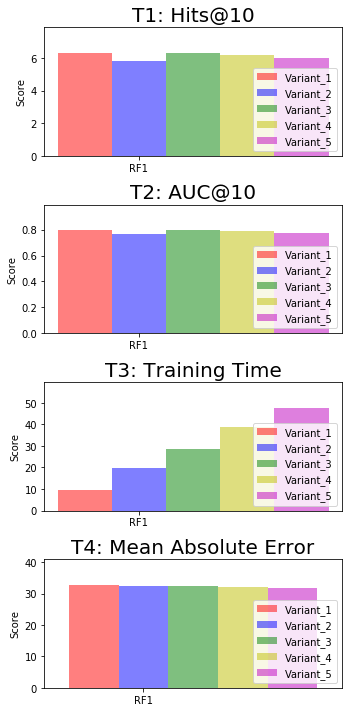

In [115]:
#update dict and show results
all_tests1 = update_dict(all_tests, 'RF1',[m1_t1, m1_t2, m1_t3, m1_t4])
show_results(all_tests1, size=(5,10))

### Model 2: Random Forest (Tuned)

In [119]:
from sklearn.model_selection import GridSearchCV

#select training data
X_train = train_dict[1].iloc[:,:-1].as_matrix()
y_train = np.ravel(train_dict[1].iloc[:,-1:].as_matrix())

# set params
model= RandomForestRegressor()
param_grid = {"max_depth": [10,15,20],
              "min_samples_split": [4,16],
              "min_samples_leaf": [4,16]}

# run grid search
grid_search = GridSearchCV(model, 
                           param_grid=param_grid, 
                           verbose=2, 
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=4 ...........
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=4, total=   2.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=4 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=4, total=   2.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=4 ...........
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=4, total=   2.7s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=16 ..........
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=16, total=   2.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=16 ..........
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=16, total=   2.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=16 ..........
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=16, total=   2.6s
[CV] max_depth=10, min_samples_leaf=16, min_samples_split=4 ..........
[CV]  max_depth=10, min_samples_leaf=16, min_samples_split=4, total=   2.6s
[CV] max_depth=10, min_samples_leaf=16, min_samples_split=4 ..........
[CV]  max_depth=10, min_samples_leaf=16, min_samples_split=4, total=   2.6s
[CV] max_depth=10, min_samples_leaf=16, min_

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 15, 20], 'min_samples_split': [4, 16], 'min_samples_leaf': [4, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=2)

In [120]:
grid_search.best_params_

{'max_depth': 15, 'min_samples_leaf': 16, 'min_samples_split': 16}

In [121]:
# extract best model
rnd_reg2 = RandomForestRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=16)
m2_t1, m2_t2, m2_t3, m2_t4 = run_tests(model_n=rnd_reg2)

Variant 1: t1= 6.8 , t2= 0.822222222222 , t3= 5.47760009765625 , t4= 25.9779865514
Variant 2: t1= 6.9 , t2= 0.827777777778 , t3= 10.853899955749512 , t4= 26.9484089974
Variant 3: t1= 6.6 , t2= 0.811111111111 , t3= 15.960700035095215 , t4= 27.5072835113
Variant 4: t1= 6.9 , t2= 0.827777777778 , t3= 21.946500062942505 , t4= 26.5266804967
Variant 5: t1= 6.7 , t2= 0.816666666667 , t3= 27.55910015106201 , t4= 26.2526632087


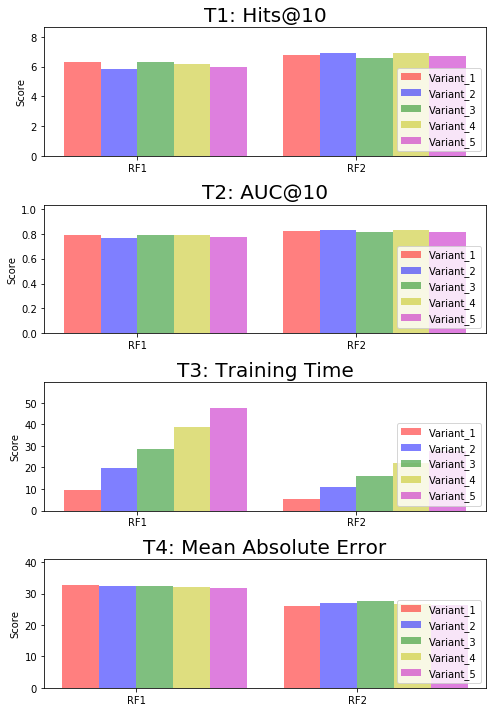

In [122]:
#update dict and show results
all_tests2 = update_dict(all_tests1,'RF2',[m2_t1, m2_t2, m2_t3, m2_t4])
show_results(all_tests2, size=(7,10))

### Model 3: Neural Net

In [108]:
m4_t1, m4_t2, m4_t3, m4_t4 = run_tests(model_n="nnet")

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000000290ED780>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'c:\\Temp\\tmp68aqdtpa'}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensor

INFO:tensorflow:global_step/sec: 230.574
INFO:tensorflow:loss = 408.088, step = 6901 (0.449 sec)
INFO:tensorflow:global_step/sec: 205.17
INFO:tensorflow:loss = 464.176, step = 7001 (0.487 sec)
INFO:tensorflow:global_step/sec: 199.322
INFO:tensorflow:loss = 5171.29, step = 7101 (0.502 sec)
INFO:tensorflow:global_step/sec: 227.635
INFO:tensorflow:loss = 90.4999, step = 7201 (0.439 sec)
INFO:tensorflow:global_step/sec: 225.073
INFO:tensorflow:loss = 259.058, step = 7301 (0.444 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 60.3774, step = 7401 (0.408 sec)
INFO:tensorflow:global_step/sec: 241.488
INFO:tensorflow:loss = 62.6591, step = 7501 (0.398 sec)
INFO:tensorflow:global_step/sec: 250
INFO:tensorflow:loss = 1495.97, step = 7601 (0.400 sec)
INFO:tensorflow:global_step/sec: 251.953
INFO:tensorflow:loss = 330.344, step = 7701 (0.397 sec)
INFO:tensorflow:global_step/sec: 250
INFO:tensorflow:loss = 269.192, step = 7801 (0.400 sec)
INFO:tensorflow:global_step/sec: 239.17

INFO:tensorflow:global_step/sec: 246.914
INFO:tensorflow:loss = 764.642, step = 15401 (0.389 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 206.381, step = 15501 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 1.55768e+08, step = 15601 (0.408 sec)
INFO:tensorflow:global_step/sec: 239.177
INFO:tensorflow:loss = 43.569, step = 15701 (0.418 sec)
INFO:tensorflow:global_step/sec: 255.167
INFO:tensorflow:loss = 99.356, step = 15801 (0.392 sec)
INFO:tensorflow:global_step/sec: 240.616
INFO:tensorflow:loss = 363.284, step = 15901 (0.416 sec)
INFO:tensorflow:global_step/sec: 250
INFO:tensorflow:loss = 827.553, step = 16001 (0.400 sec)
INFO:tensorflow:global_step/sec: 250
INFO:tensorflow:loss = 668.805, step = 16101 (0.400 sec)
INFO:tensorflow:global_step/sec: 250
INFO:tensorflow:loss = 92.2799, step = 16201 (0.400 sec)
INFO:tensorflow:global_step/sec: 252.334
INFO:tensorflow:loss = 15089.9, step = 16301 (0.412 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:loss = 1496.19, step = 23801 (0.470 sec)
INFO:tensorflow:global_step/sec: 143.554
INFO:tensorflow:loss = 182.389, step = 23901 (0.697 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 660.101, step = 24001 (0.408 sec)
INFO:tensorflow:global_step/sec: 177.273
INFO:tensorflow:loss = 108.186, step = 24101 (0.564 sec)
INFO:tensorflow:global_step/sec: 165.865
INFO:tensorflow:loss = 122.603, step = 24201 (0.603 sec)
INFO:tensorflow:global_step/sec: 164.609
INFO:tensorflow:loss = 480.137, step = 24301 (0.607 sec)
INFO:tensorflow:global_step/sec: 169.205
INFO:tensorflow:loss = 6732.29, step = 24401 (0.607 sec)
INFO:tensorflow:global_step/sec: 187.653
INFO:tensorflow:loss = 11853.0, step = 24501 (0.518 sec)
INFO:tensorflow:global_step/sec: 182.349
INFO:tensorflow:loss = 139.93, step = 24601 (0.563 sec)
INFO:tensorflow:global_step/sec: 228.885
INFO:tensorflow:loss = 60.3315, step = 24701 (0.421 sec)
INFO:tensorflow:global_step/sec: 200.521
INFO:tensorflow:loss 

INFO:tensorflow:loss = 2651.92, step = 32201 (0.436 sec)
INFO:tensorflow:global_step/sec: 243.546
INFO:tensorflow:loss = 66.0959, step = 32301 (0.411 sec)
INFO:tensorflow:global_step/sec: 251.889
INFO:tensorflow:loss = 110.541, step = 32401 (0.413 sec)
INFO:tensorflow:global_step/sec: 212.54
INFO:tensorflow:loss = 128.389, step = 32501 (0.471 sec)
INFO:tensorflow:global_step/sec: 226.347
INFO:tensorflow:loss = 1746.67, step = 32601 (0.442 sec)
INFO:tensorflow:global_step/sec: 212.54
INFO:tensorflow:loss = 1337.35, step = 32701 (0.455 sec)
INFO:tensorflow:global_step/sec: 205.719
INFO:tensorflow:loss = 118.333, step = 32801 (0.502 sec)
INFO:tensorflow:global_step/sec: 217.675
INFO:tensorflow:loss = 12417.2, step = 32901 (0.444 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 212.194, step = 33001 (0.439 sec)
INFO:tensorflow:global_step/sec: 218.627
INFO:tensorflow:loss = 91.9542, step = 33101 (0.442 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss =

INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmp68aqdtpa\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tm

INFO:tensorflow:global_step/sec: 214.5
INFO:tensorflow:loss = 128.096, step = 3701 (0.466 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 49.3637, step = 3801 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 6482.51, step = 3901 (0.424 sec)
INFO:tensorflow:global_step/sec: 233.59
INFO:tensorflow:loss = 4103.14, step = 4001 (0.413 sec)
INFO:tensorflow:global_step/sec: 242.072
INFO:tensorflow:loss = 9.0433, step = 4101 (0.429 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 39317.0, step = 4201 (0.408 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 520.421, step = 4301 (0.392 sec)
INFO:tensorflow:global_step/sec: 227.635
INFO:tensorflow:loss = 64.4067, step = 4401 (0.439 sec)
INFO:tensorflow:global_step/sec: 248.818
INFO:tensorflow:loss = 2352.04, step = 4501 (0.402 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 414.542, step = 4601 (0.408 sec)
INFO:tensorflow:global_step/sec: 2

INFO:tensorflow:global_step/sec: 231.214
INFO:tensorflow:loss = 1938.29, step = 12201 (0.432 sec)
INFO:tensorflow:global_step/sec: 210.217
INFO:tensorflow:loss = 292.674, step = 12301 (0.471 sec)
INFO:tensorflow:global_step/sec: 243.546
INFO:tensorflow:loss = 40.8495, step = 12401 (0.426 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 813.689, step = 12501 (0.392 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 657.498, step = 12601 (0.408 sec)
INFO:tensorflow:global_step/sec: 227.635
INFO:tensorflow:loss = 57.593, step = 12701 (0.439 sec)
INFO:tensorflow:global_step/sec: 245.399
INFO:tensorflow:loss = 3909.88, step = 12801 (0.408 sec)
INFO:tensorflow:global_step/sec: 233.209
INFO:tensorflow:loss = 5842.58, step = 12901 (0.429 sec)
INFO:tensorflow:global_step/sec: 219.829
INFO:tensorflow:loss = 1947.41, step = 13001 (0.470 sec)
INFO:tensorflow:global_step/sec: 219.829
INFO:tensorflow:loss = 1125.28, step = 13101 (0.439 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 250.376
INFO:tensorflow:loss = 203.566, step = 20601 (0.415 sec)
INFO:tensorflow:global_step/sec: 229.568
INFO:tensorflow:loss = 70.9874, step = 20701 (0.436 sec)
INFO:tensorflow:global_step/sec: 233.263
INFO:tensorflow:loss = 489.334, step = 20801 (0.413 sec)
INFO:tensorflow:global_step/sec: 251.572
INFO:tensorflow:loss = 1013.96, step = 20901 (0.398 sec)
INFO:tensorflow:global_step/sec: 240.616
INFO:tensorflow:loss = 304.914, step = 21001 (0.416 sec)
INFO:tensorflow:global_step/sec: 256.805
INFO:tensorflow:loss = 114.637, step = 21101 (0.405 sec)
INFO:tensorflow:global_step/sec: 235.294
INFO:tensorflow:loss = 495.432, step = 21201 (0.425 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 7963.56, step = 21301 (0.392 sec)
INFO:tensorflow:global_step/sec: 240.964
INFO:tensorflow:loss = 180.736, step = 21401 (0.415 sec)
INFO:tensorflow:global_step/sec: 233.263
INFO:tensorflow:loss = 80.6899, step = 21501 (0.429 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 237.8, step = 29001 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 63.3012, step = 29101 (0.392 sec)
INFO:tensorflow:global_step/sec: 226.654
INFO:tensorflow:loss = 186.483, step = 29201 (0.441 sec)
INFO:tensorflow:global_step/sec: 235.96
INFO:tensorflow:loss = 9.58555, step = 29301 (0.424 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 2680.73, step = 29401 (0.424 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 1575.98, step = 29501 (0.408 sec)
INFO:tensorflow:global_step/sec: 211.372
INFO:tensorflow:loss = 60.8768, step = 29601 (0.473 sec)
INFO:tensorflow:global_step/sec: 198.334
INFO:tensorflow:loss = 97.8018, step = 29701 (0.504 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 86.2505, step = 29801 (0.408 sec)
INFO:tensorflow:global_step/sec: 233.318
INFO:tensorflow:loss = 121.983, step = 29901 (0.429 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 237.756
INFO:tensorflow:loss = 2259.03, step = 37401 (0.421 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 238.598, step = 37501 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 725.13, step = 37601 (0.408 sec)
INFO:tensorflow:global_step/sec: 246.913
INFO:tensorflow:loss = 6170.23, step = 37701 (0.405 sec)
INFO:tensorflow:global_step/sec: 246.914
INFO:tensorflow:loss = 2775.88, step = 37801 (0.389 sec)
INFO:tensorflow:global_step/sec: 233.918
INFO:tensorflow:loss = 119.746, step = 37901 (0.428 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 316.882, step = 38001 (0.408 sec)
INFO:tensorflow:global_step/sec: 244.439
INFO:tensorflow:loss = 204.332, step = 38101 (0.394 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 906.539, step = 38201 (0.408 sec)
INFO:tensorflow:global_step/sec: 236.351
INFO:tensorflow:loss = 222.342, step = 38301 (0.408 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 251.572
INFO:tensorflow:loss = 5073.45, step = 401 (0.398 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 344.825, step = 501 (0.408 sec)
INFO:tensorflow:global_step/sec: 253.165
INFO:tensorflow:loss = 571.824, step = 601 (0.395 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 70.9951, step = 701 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.518
INFO:tensorflow:loss = 539.538, step = 801 (0.393 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 532.295, step = 901 (0.408 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 75.4603, step = 1001 (0.392 sec)
INFO:tensorflow:global_step/sec: 242.072
INFO:tensorflow:loss = 4955.96, step = 1101 (0.429 sec)
INFO:tensorflow:global_step/sec: 234.632
INFO:tensorflow:loss = 101.617, step = 1201 (0.411 sec)
INFO:tensorflow:global_step/sec: 216.263
INFO:tensorflow:loss = 166.466, step = 1301 (0.462 sec)
INFO:tensorflow:global_step/sec: 242

INFO:tensorflow:global_step/sec: 219.829
INFO:tensorflow:loss = 63.789, step = 8901 (0.455 sec)
INFO:tensorflow:global_step/sec: 242.777
INFO:tensorflow:loss = 6615.99, step = 9001 (0.412 sec)
INFO:tensorflow:global_step/sec: 239.177
INFO:tensorflow:loss = 636.091, step = 9101 (0.418 sec)
INFO:tensorflow:global_step/sec: 253.164
INFO:tensorflow:loss = 164.919, step = 9201 (0.395 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 181.587, step = 9301 (0.424 sec)
INFO:tensorflow:global_step/sec: 223.814
INFO:tensorflow:loss = 4403.64, step = 9401 (0.431 sec)
INFO:tensorflow:global_step/sec: 210.97
INFO:tensorflow:loss = 1111.63, step = 9501 (0.474 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 2682.56, step = 9601 (0.393 sec)
INFO:tensorflow:global_step/sec: 233.264
INFO:tensorflow:loss = 492.69, step = 9701 (0.429 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 42.1351, step = 9801 (0.439 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 209.996
INFO:tensorflow:loss = 158.221, step = 17301 (0.476 sec)
INFO:tensorflow:global_step/sec: 196.386
INFO:tensorflow:loss = 161.349, step = 17401 (0.525 sec)
INFO:tensorflow:global_step/sec: 218.293
INFO:tensorflow:loss = 82.4725, step = 17501 (0.458 sec)
INFO:tensorflow:global_step/sec: 157.654
INFO:tensorflow:loss = 2135.53, step = 17601 (0.634 sec)
INFO:tensorflow:global_step/sec: 232.234
INFO:tensorflow:loss = 135.079, step = 17701 (0.431 sec)
INFO:tensorflow:global_step/sec: 219.829
INFO:tensorflow:loss = 666.034, step = 17801 (0.439 sec)
INFO:tensorflow:global_step/sec: 246.914
INFO:tensorflow:loss = 837.629, step = 17901 (0.405 sec)
INFO:tensorflow:global_step/sec: 225.428
INFO:tensorflow:loss = 608.832, step = 18001 (0.444 sec)
INFO:tensorflow:global_step/sec: 215.146
INFO:tensorflow:loss = 260.803, step = 18101 (0.470 sec)
INFO:tensorflow:global_step/sec: 232.721
INFO:tensorflow:loss = 65.5961, step = 18201 (0.425 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 223.814
INFO:tensorflow:loss = 241.877, step = 25701 (0.447 sec)
INFO:tensorflow:global_step/sec: 227.635
INFO:tensorflow:loss = 506.1, step = 25801 (0.424 sec)
INFO:tensorflow:global_step/sec: 204.082
INFO:tensorflow:loss = 587.409, step = 25901 (0.490 sec)
INFO:tensorflow:global_step/sec: 234.632
INFO:tensorflow:loss = 46.0224, step = 26001 (0.426 sec)
INFO:tensorflow:global_step/sec: 223.464
INFO:tensorflow:loss = 843.206, step = 26101 (0.448 sec)
INFO:tensorflow:global_step/sec: 219.635
INFO:tensorflow:loss = 82.8498, step = 26201 (0.455 sec)
INFO:tensorflow:global_step/sec: 248.447
INFO:tensorflow:loss = 63.5166, step = 26301 (0.418 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 6225.62, step = 26401 (0.408 sec)
INFO:tensorflow:global_step/sec: 243.546
INFO:tensorflow:loss = 4453.95, step = 26501 (0.395 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 745.982, step = 26601 (0.408 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 174.338
INFO:tensorflow:loss = 7736.03, step = 34101 (0.589 sec)
INFO:tensorflow:global_step/sec: 197.316
INFO:tensorflow:loss = 63.3467, step = 34201 (0.491 sec)
INFO:tensorflow:global_step/sec: 168.976
INFO:tensorflow:loss = 5169.77, step = 34301 (0.592 sec)
INFO:tensorflow:global_step/sec: 166.141
INFO:tensorflow:loss = 164.85, step = 34401 (0.602 sec)
INFO:tensorflow:global_step/sec: 242.072
INFO:tensorflow:loss = 1118.62, step = 34501 (0.413 sec)
INFO:tensorflow:global_step/sec: 231.911
INFO:tensorflow:loss = 491.792, step = 34601 (0.447 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 501.0, step = 34701 (0.408 sec)
INFO:tensorflow:global_step/sec: 233.263
INFO:tensorflow:loss = 5401.88, step = 34801 (0.429 sec)
INFO:tensorflow:global_step/sec: 227.635
INFO:tensorflow:loss = 6412.38, step = 34901 (0.439 sec)
INFO:tensorflow:global_step/sec: 233.863
INFO:tensorflow:loss = 479.77, step = 35001 (0.428 sec)
INFO:tensorflow:global_s

INFO:tensorflow:Restoring parameters from c:\Temp\tmpdfpvllg7\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmpdfpvllg7\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmpdfpvllg7\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmpdfpvllg7\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmpdfpvllg7\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmpdfpvllg7\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmpdfpvllg7\model.ckpt-40000
Variant 3: t1= 1.0 , t2= 0.503333333333 , t3= 180.4335000514984 , t4= 30.1559998537
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000001D8DA908>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 

INFO:tensorflow:global_step/sec: 256.805
INFO:tensorflow:loss = 85.5234, step = 5601 (0.389 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 46.7429, step = 5701 (0.408 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 89081.7, step = 5801 (0.393 sec)
INFO:tensorflow:global_step/sec: 236.351
INFO:tensorflow:loss = 138.106, step = 5901 (0.423 sec)
INFO:tensorflow:global_step/sec: 242.072
INFO:tensorflow:loss = 850.098, step = 6001 (0.413 sec)
INFO:tensorflow:global_step/sec: 145.159
INFO:tensorflow:loss = 25.3539, step = 6101 (0.689 sec)
INFO:tensorflow:global_step/sec: 156.299
INFO:tensorflow:loss = 366.487, step = 6201 (0.655 sec)
INFO:tensorflow:global_step/sec: 176.491
INFO:tensorflow:loss = 692.875, step = 6301 (0.551 sec)
INFO:tensorflow:global_step/sec: 182.315
INFO:tensorflow:loss = 41.3087, step = 6401 (0.549 sec)
INFO:tensorflow:global_step/sec: 213.95
INFO:tensorflow:loss = 8782.72, step = 6501 (0.483 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:loss = 422.822, step = 14001 (0.416 sec)
INFO:tensorflow:global_step/sec: 247.831
INFO:tensorflow:loss = 66.0557, step = 14101 (0.404 sec)
INFO:tensorflow:global_step/sec: 247.28
INFO:tensorflow:loss = 91.6404, step = 14201 (0.420 sec)
INFO:tensorflow:global_step/sec: 242.424
INFO:tensorflow:loss = 612.91, step = 14301 (0.412 sec)
INFO:tensorflow:global_step/sec: 215.239
INFO:tensorflow:loss = 197.627, step = 14401 (0.449 sec)
INFO:tensorflow:global_step/sec: 243.546
INFO:tensorflow:loss = 143.895, step = 14501 (0.411 sec)
INFO:tensorflow:global_step/sec: 248.447
INFO:tensorflow:loss = 56.2736, step = 14601 (0.403 sec)
INFO:tensorflow:global_step/sec: 242.072
INFO:tensorflow:loss = 141.877, step = 14701 (0.413 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 192.129, step = 14801 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 1044.39, step = 14901 (0.392 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss =

INFO:tensorflow:loss = 8645.0, step = 22401 (0.429 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 219.639, step = 22501 (0.408 sec)
INFO:tensorflow:global_step/sec: 243.546
INFO:tensorflow:loss = 45.4704, step = 22601 (0.411 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 2156.8, step = 22701 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 7802.85, step = 22801 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 54.8422, step = 22901 (0.393 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 303.48, step = 23001 (0.408 sec)
INFO:tensorflow:global_step/sec: 242.072
INFO:tensorflow:loss = 6321.91, step = 23101 (0.398 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 120.688, step = 23201 (0.408 sec)
INFO:tensorflow:global_step/sec: 219.829
INFO:tensorflow:loss = 790.844, step = 23301 (0.471 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 

INFO:tensorflow:global_step/sec: 240.616
INFO:tensorflow:loss = 3972.45, step = 30901 (0.416 sec)
INFO:tensorflow:global_step/sec: 218.627
INFO:tensorflow:loss = 119.613, step = 31001 (0.473 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 598.713, step = 31101 (0.392 sec)
INFO:tensorflow:global_step/sec: 253.164
INFO:tensorflow:loss = 7969.45, step = 31201 (0.395 sec)
INFO:tensorflow:global_step/sec: 251.953
INFO:tensorflow:loss = 873.119, step = 31301 (0.412 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 340.405, step = 31401 (0.392 sec)
INFO:tensorflow:global_step/sec: 243.546
INFO:tensorflow:loss = 690.108, step = 31501 (0.411 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 82.5637, step = 31601 (0.393 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 72.3363, step = 31701 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 744.325, step = 31801 (0.392 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 255.167
INFO:tensorflow:loss = 280.022, step = 39301 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 1498.93, step = 39401 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.399
INFO:tensorflow:loss = 808.456, step = 39501 (0.392 sec)
INFO:tensorflow:global_step/sec: 253.164
INFO:tensorflow:loss = 230.209, step = 39601 (0.395 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 1413.23, step = 39701 (0.408 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 491.677, step = 39801 (0.392 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 188.755, step = 39901 (0.392 sec)
INFO:tensorflow:Saving checkpoints for 40000 into c:\Temp\tmpg4hvxx60\model.ckpt.
INFO:tensorflow:Loss for final step: 187.23.
INFO:tensorflow:Restoring parameters from c:\Temp\tmpg4hvxx60\model.ckpt-40000
INFO:tensorflow:Restoring parameters from c:\Temp\tmpg4hvxx60\model.ckpt-40000
INFO:tensorflow:Restoring par

INFO:tensorflow:global_step/sec: 246.913
INFO:tensorflow:loss = 125.972, step = 2301 (0.405 sec)
INFO:tensorflow:global_step/sec: 260.214
INFO:tensorflow:loss = 240.803, step = 2401 (0.390 sec)
INFO:tensorflow:global_step/sec: 222.025
INFO:tensorflow:loss = 5795.35, step = 2501 (0.444 sec)
INFO:tensorflow:global_step/sec: 235.571
INFO:tensorflow:loss = 3937.09, step = 2601 (0.431 sec)
INFO:tensorflow:global_step/sec: 230.947
INFO:tensorflow:loss = 7991.19, step = 2701 (0.443 sec)
INFO:tensorflow:global_step/sec: 197.511
INFO:tensorflow:loss = 2129.89, step = 2801 (0.491 sec)
INFO:tensorflow:global_step/sec: 227.946
INFO:tensorflow:loss = 443.165, step = 2901 (0.454 sec)
INFO:tensorflow:global_step/sec: 207.039
INFO:tensorflow:loss = 18.5781, step = 3001 (0.467 sec)
INFO:tensorflow:global_step/sec: 234.742
INFO:tensorflow:loss = 3759.21, step = 3101 (0.431 sec)
INFO:tensorflow:global_step/sec: 181.752
INFO:tensorflow:loss = 50777.0, step = 3201 (0.545 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:global_step/sec: 245.399
INFO:tensorflow:loss = 148.439, step = 10801 (0.423 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 229.949, step = 10901 (0.392 sec)
INFO:tensorflow:global_step/sec: 253.165
INFO:tensorflow:loss = 32881.0, step = 11001 (0.395 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 351.967, step = 11101 (0.408 sec)
INFO:tensorflow:global_step/sec: 255.167
INFO:tensorflow:loss = 361.506, step = 11201 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 2709.7, step = 11301 (0.408 sec)
INFO:tensorflow:global_step/sec: 243.902
INFO:tensorflow:loss = 35.2861, step = 11401 (0.394 sec)
INFO:tensorflow:global_step/sec: 250.376
INFO:tensorflow:loss = 2669.92, step = 11501 (0.399 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 150.109, step = 11601 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 289.381, step = 11701 (0.393 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 246.914
INFO:tensorflow:loss = 760.997, step = 19201 (0.405 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 366.11, step = 19301 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 296.321, step = 19401 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 45.748, step = 19501 (0.408 sec)
INFO:tensorflow:global_step/sec: 243.546
INFO:tensorflow:loss = 59.6365, step = 19601 (0.395 sec)
INFO:tensorflow:global_step/sec: 227.946
INFO:tensorflow:loss = 890.389, step = 19701 (0.439 sec)
INFO:tensorflow:global_step/sec: 253.164
INFO:tensorflow:loss = 93.9986, step = 19801 (0.395 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 20786.6, step = 19901 (0.408 sec)
INFO:tensorflow:global_step/sec: 219.829
INFO:tensorflow:loss = 113.917, step = 20001 (0.455 sec)
INFO:tensorflow:global_step/sec: 248.447
INFO:tensorflow:loss = 304.284, step = 20101 (0.402 sec)
INFO:tensorflow:global

INFO:tensorflow:loss = 78.7646, step = 27601 (0.405 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 188.019, step = 27701 (0.408 sec)
INFO:tensorflow:global_step/sec: 240.964
INFO:tensorflow:loss = 201.227, step = 27801 (0.431 sec)
INFO:tensorflow:global_step/sec: 236.351
INFO:tensorflow:loss = 96.8227, step = 27901 (0.423 sec)
INFO:tensorflow:global_step/sec: 236.016
INFO:tensorflow:loss = 247.415, step = 28001 (0.408 sec)
INFO:tensorflow:global_step/sec: 240.616
INFO:tensorflow:loss = 2288.99, step = 28101 (0.416 sec)
INFO:tensorflow:global_step/sec: 240.616
INFO:tensorflow:loss = 227.241, step = 28201 (0.416 sec)
INFO:tensorflow:global_step/sec: 250
INFO:tensorflow:loss = 952.173, step = 28301 (0.400 sec)
INFO:tensorflow:global_step/sec: 227.48
INFO:tensorflow:loss = 106.556, step = 28401 (0.440 sec)
INFO:tensorflow:global_step/sec: 235.96
INFO:tensorflow:loss = 145.188, step = 28501 (0.424 sec)
INFO:tensorflow:global_step/sec: 234.247
INFO:tensorflow:loss = 587

INFO:tensorflow:global_step/sec: 231.214
INFO:tensorflow:loss = 100.389, step = 36101 (0.417 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 3063.24, step = 36201 (0.408 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 418.851, step = 36301 (0.408 sec)
INFO:tensorflow:global_step/sec: 219.829
INFO:tensorflow:loss = 151.922, step = 36401 (0.439 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 499.596, step = 36501 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 1571.19, step = 36601 (0.392 sec)
INFO:tensorflow:global_step/sec: 260.146
INFO:tensorflow:loss = 1307.41, step = 36701 (0.400 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 193.547, step = 36801 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.777
INFO:tensorflow:loss = 578.492, step = 36901 (0.408 sec)
INFO:tensorflow:global_step/sec: 245.038
INFO:tensorflow:loss = 279.4, step = 37001 (0.392 sec)
INFO:tensorflow:global

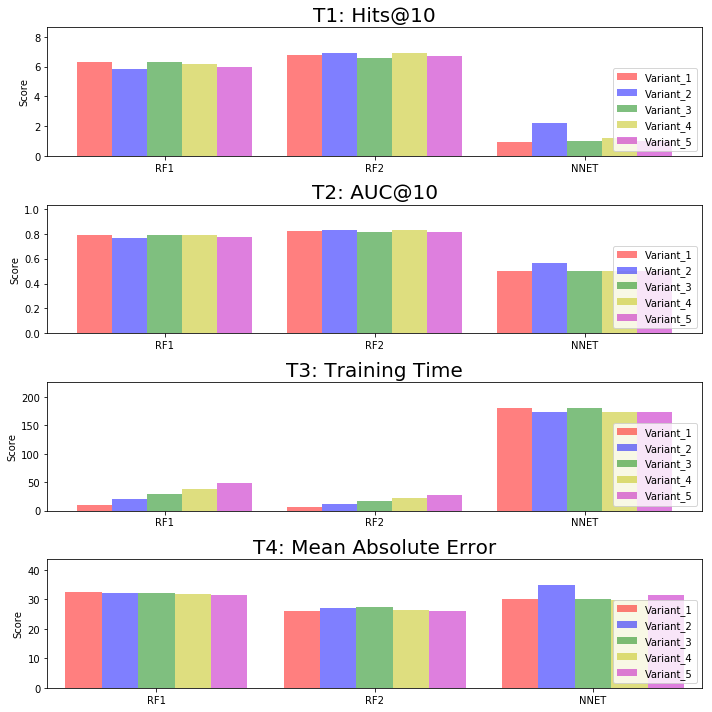

In [123]:
all_tests3 = update_dict(all_tests2,'NNET',[m4_t1, m4_t2, m4_t3, m4_t4])
show_results(all_tests3, size=(10,10))